# Runtime of Minimization Methods for Shadow Ban with Control Package

This notebook uses the `control` package to solve for shadow banning policies.

In [ ]:
!pip install control

In [1]:
import numpy as np
import control.optimal as obc
import control as ct

import matplotlib.pyplot as plt
from scripts.content_moderation import *
import networkx as nx

import winsound
import pandas as pd
import time
import seaborn as sns
import scipy.optimize 

# Load Network

For your network model you need the following inputs:

   1. `A` = adjacency matrix of graph G0
   2. `rates` = array of posting rate of each node
   3. `tau`, `omega` = shift function parameters
   4. `opinions0` = array of initial opinions of each node

In [2]:
omega = 1 # strength of persuasion
tau = .50 # confidence interval, easiness to pursuade

nv = 1000
G0 = nx.DiGraph(nx.path_graph(nv) )
for i in range(nv):
    rate = 1
    opinion = i/(nv-1) * 1
    G0.add_node(i, opinion=opinion, rate=rate)
                
rates = np.array([G0.nodes[v]["rate"] for v in G0.nodes()])
opinions0 = np.array([G0.nodes[v]["opinion"] for v in G0.nodes()])


#adjacency matrix of network
A = nx.adjacency_matrix(G0)
A = A.tocoo()
ne = G0.number_of_edges()
#names of edges for shadowbanning in format uij
input_names = []
for e in G0.edges():
    input_names.append(f"u{e[0]}{e[1]}")
#names of nodes opinions in format thetai
output_names = []
for v in G0.nodes():
    output_names.append(f"theta{v}")
    
assert nv == A.shape[0]  #number of nodes in network should equal shape of A
#parameters of network model
params = {'A':A,'rates':rates,'tau':tau,'omega':omega}





# Helper Functions

1. `sys_update` = function that returns time derivative of opinions
2. `sys_output` = returns opinions as output of system (not really needed, but whatever)
3. `cost_fun_XXX` = cost function of opinions and control.  This function is time integrated to give the cumulative cost.  The code minimizes this cost.  Make it whatever you like. I found doing linear and quadratic functions makes the code faster, so don't use standard deviation.

# Create Nonlinear IO System Object

In [3]:
def sys_update(t, x, u, params):
    # Get the parameters for the model
    A = params.get('A')         # vehicle wheelbase
    rates = params.get('rates')
    tau = params.get('tau')
    omega = params.get('omega')
    
    
    # Create COO matrix U with data from u at A's locations
    
    U_row = A.row
    U_col = A.col
    U = coo_matrix((u, (U_row, U_col)), shape=(A.shape[0], A.shape[1]))

    # Return the derivative of the state
    return dxdt(x, t, rates, A, tau, omega, U)

def sys_output(t, x, u, params):
    return x                            # return x, y, theta (full state)

sys = ct.NonlinearIOSystem(
    sys_update, sys_output, states=nv,
    inputs=input_names, outputs = output_names,
    name='path network', params=params)

alpha = 0.0

#inital conditions 
x0 = opinions0
#initial guess of control
u0 = np.ones(ne)
Tf = 30
npts, npts_eval = 3, 100
#bounds on control strength
constraints = [ obc.input_range_constraint(sys, np.zeros(ne), np.ones(ne)) ]


U0 =  np.vstack([u0] * npts).T

timepts = np.linspace(0, Tf, npts, endpoint=True)
t_eval = np.linspace(0, Tf, npts_eval)

#Objective Function
def cost_mean(x, u):
    return -x.mean()/Tf - alpha*u.mean()/Tf

#Objective Function
def cost_varmax(x, u):
    return -x.var()/Tf - alpha*u.mean()/Tf

#Objective Function
def cost_varmin(x, u):
    return x.var()/Tf - alpha*u.mean()/Tf

# Test Optimization Methods

In [ ]:
#ct.config.defaults['optimal.minimize_options'] = {'maxiter':101}
reward_max = 2
minimize_methods = ['default','Nelder-Mead','Powell', 'CG','BFGS',
                    'L-BFGS-B', 'TNC', 'SLSQP']
data = []
for minimize_method in minimize_methods:
    try:
        if minimize_method == 'default':
            ct.config.defaults['optimal.minimize_method'] = None
        else:
            ct.config.defaults['optimal.minimize_method'] = minimize_method
        
        start_time = time.time()
        result = obc.solve_ocp(
            sys, timepts, x0, 
            cost_mean, 
            constraints,
            initial_guess=u0, print_summary=False)

        # Calculate the runtime
        runtime = time.time() - start_time
        reward = -result.cost
        # Print the runtime and function value
        print(f"{minimize_method}: {runtime:.6f} sec, optimal reward: {reward}")
        data.append({'Method':minimize_method,'Reward':reward,'Runtime':runtime})
        
        if reward <=reward_max:
            resp = ct.input_output_response(
                    sys, timepts, result.inputs, x0,
                    t_eval= t_eval, params = params)


            T, Opinions, U = resp.time, resp.outputs, resp.inputs
            Opinions = Opinions.T
            Shadow_ban_strength = 1-U.mean(axis=0)
            plt.figure(figsize = (10,4))
            plt.subplot(1,2,1)
            plt.plot(T, Opinions)
            plt.grid()
            plt.xlabel("Time")
            plt.ylabel("Opinions")
            plt.ylim([0,1.1])
            plt.title(f"{minimize_method}: Reward = {reward:.2f}")

            plt.subplot(1,2,2)
            plt.plot(T,Shadow_ban_strength)
            plt.grid()
            plt.xlabel("Time")
            plt.ylabel("Mean Shadow Ban Strength")
            plt.ylim([0,1.1])
            plt.show()
        
    except Exception as e:
        print(f"\tError with {minimize_method}: {e}")

    

df = pd.DataFrame(data)
plt.figure(figsize = (14,4))
plt.subplot(1,2,1)
sns.barplot(data=df, x = 'Method', y = 'Runtime')
plt.xticks(rotation=90)
plt.yscale('log')
plt.grid()
plt.subplot(1,2,2)
sns.barplot(data=df, x = 'Method', y = 'Reward')
plt.xticks(rotation=90)
plt.yscale('log')
plt.grid()
plt.title("Cost = Mean")
plt.show()


# Plot the Objective Value vs Iteration

In [ ]:
integral_cost = cost_mean
maxiter = 100

def callback(coeffs):
    #print(len(coeffs))
    x = coeffs[-nv * npts:].reshape(nv, -1)
    coeffs = coeffs[:-nv * npts]
    #print(len(coeffs))
    u = coeffs.reshape((ne, -1))
    
    costs = [integral_cost(x[:, i], u[:, i]) for
                     i in range(npts)]

            # Compute the time intervals
    dt = np.diff(timepts)

    # Integrate the cost
    # TODO: vectorize
    cost = 0
    for i in range(npts-1):
        # Approximate the integral using trapezoidal rule
        cost += 0.5 * (costs[i] + costs[i+1]) * dt[i]
    obj_value = cost
    print(f"Obj = {obj_value:.3f}")
    objective_values.append(obj_value)
    
    

ct.config.defaults['optimal.minimize_method'] = 'SLSQP'
ct.config.defaults['optimal.minimize_options'] = {'disp':True,'maxiter':maxiter}
ct.config.defaults['optimal.minimize_kwargs'] = {'callback':callback}

objective_values = []
result = obc.solve_ocp(
        sys, timepts, x0, 
        integral_cost, 
        constraints,
        initial_guess=u0, print_summary=False)


#######################################################
df = pd.DataFrame({'Iteration': range(len(objective_values)), 'Objective': objective_values})
plt.figure(figsize = (6,4))

sns.lineplot(data = df, x = 'Iteration', y = 'Objective', marker = 'o')
plt.title(f"{nv} nodes: {integral_cost.__name__}")
plt.grid()
plt.show()

# Plot Opinions for Each Maxiter Value

Iteration limit reached    (Exit mode 9)
            Current function value: -0.1323961277633964
            Iterations: 10
            Function evaluations: 8950
            Gradient evaluations: 10
'SLSQP' maxiter = 10: 116.773916 sec, optimal reward: 0.1323961277633964


C:\Users\trz2\Anaconda3\lib\site-packages\control\optimal.py:913: UserWarning: unable to solve optimal control problem
scipy.optimize.minimize returned Iteration limit reached
  warnings.warn(


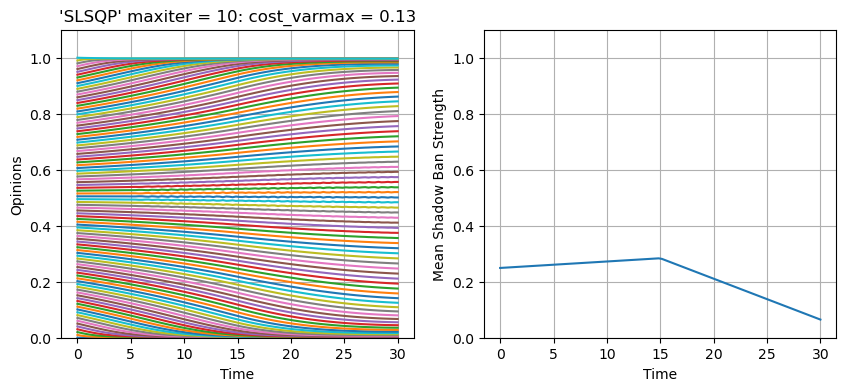

Iteration limit reached    (Exit mode 9)
            Current function value: -0.13935459174862577
            Iterations: 20
            Function evaluations: 17900
            Gradient evaluations: 20
'SLSQP' maxiter = 20: 209.365675 sec, optimal reward: 0.13935459174862577


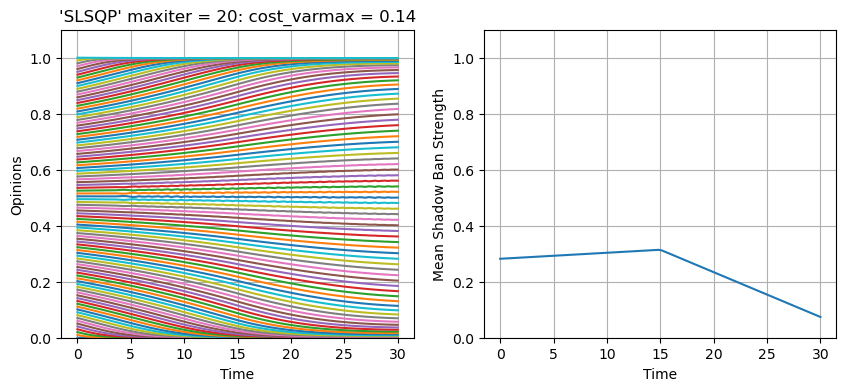

Iteration limit reached    (Exit mode 9)
            Current function value: -0.14519448318133277
            Iterations: 30
            Function evaluations: 26850
            Gradient evaluations: 30
'SLSQP' maxiter = 30: 260.539546 sec, optimal reward: 0.14519448318133277


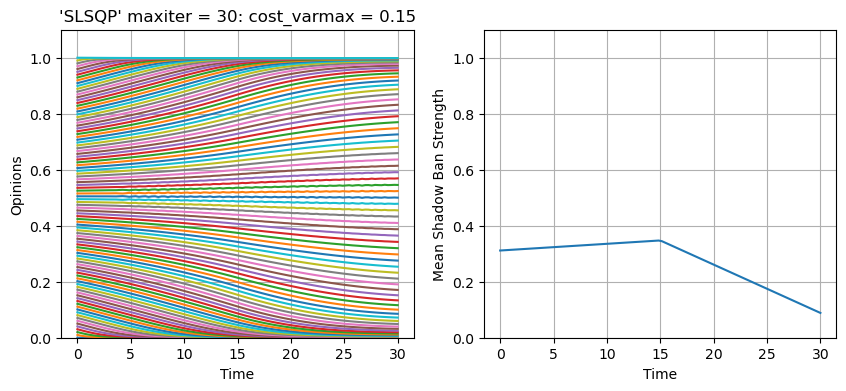

In [30]:
t = np.arange(80, 100, 10)  # Original array
values = np.array([5, 10, 20, 30, 40])  # Values to append
new_t = np.concatenate((values, t))
new_t = [10, 20, 30]
integral_cost = cost_varmax
for maxiter in new_t:
    ct.config.defaults['optimal.minimize_method'] = 'SLSQP'
    ct.config.defaults['optimal.minimize_options'] = {'disp':True,'maxiter':maxiter}

    start_time = time.time()
    result = obc.solve_ocp(
        sys, timepts, x0, 
        integral_cost, 
        constraints,
        initial_guess=u0, print_summary=False)

    # Calculate the runtime
    runtime = time.time() - start_time
    reward = -result.cost
    print(f"'SLSQP' maxiter = {maxiter}: {runtime:.6f} sec, optimal reward: {reward}")



    resp = ct.input_output_response(
                        sys, timepts, result.inputs, x0,
                        t_eval= t_eval, params = params)

    T, Opinions, U = resp.time, resp.outputs, resp.inputs
    Opinions = Opinions.T
    Shadow_ban_strength = 1-U.mean(axis=0)
    plt.figure(figsize = (10,4))
    plt.subplot(1,2,1)
    plt.plot(T, Opinions)
    plt.grid()
    plt.xlabel("Time")
    plt.ylabel("Opinions")
    plt.ylim([0,1.1])
    plt.title(f"'SLSQP' maxiter = {maxiter}: {integral_cost.__name__} = {reward:.2f}")

    plt.subplot(1,2,2)
    plt.plot(T,Shadow_ban_strength)
    plt.grid()
    plt.xlabel("Time")
    plt.ylabel("Mean Shadow Ban Strength")
    plt.ylim([0,1.1])
    plt.show()
    if result.message=='Optimization terminated successfully':
        break